###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):**     `1086220, 1068172`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
from collections import defaultdict
from math import sqrt
import numpy as np
import pandas as pd
import math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
'''
This function takes in a file path and convert the csv file 
and returns 2d array (list of rows) and class label
'''
def preprocess(file):
    # read in file
    df = pd.read_csv(file, header = None)
    df = df.replace(9999, np.nan)
    
    # extract class label and atributes
    label = df.iloc[:,0] 
    data = df.iloc[:,1:]
    
    X = data.values.tolist()
    y = label.values.tolist()
    
    return X, y

In [3]:
'''
This function takes a list of numerical values as its input
returns the mean (ignoring any missing values)
'''
def sample_mean(data_points):
    
    sum_values = 0
    total_points = 0
    
    for points in range(0, len(data_points)):
        if not(np.isnan(data_points[points])):
            sum_values += data_points[points]
            total_points += 1
    return sum_values / total_points        


'''
This function takes a list of numerical values as its input
returns the standard deviation (ignoring any missing values)
'''
def sample_std(data_points):
    
    # get the mean of the data
    data_mean = sample_mean(data_points)
    
    sum_squares = 0
    total_points = 0
    for points in range(0, len(data_points)):
        if not(np.isnan(data_points[points])):
            sum_squares += (data_points[points] - data_mean) * (data_points[points] - data_mean)
            total_points += 1
    
    return sqrt(sum_squares / (total_points -  1))


'''
This function takes an integer representing the number of empty lists 
needed to be initialise within the main list.
Returns a list of empty lists in which the number of empty list is defined by inner_list_num    
'''
def init_2D_array(inner_list_num):
    
    array = []
    for i in range(inner_list_num):
        array.append([])
    return array   


'''
This function takes as its input: a 2D array containing the instances (excluding the class), 
and a list of the class that correspond to each instance
Returns two outputs:
1. a dictionary ("prior_prob") that stores the prior probabilities of each class as its value and class as a key. 
2. a dictionary of 2D array ("mean_std_dict") with the class as its keys, and the values storing a 2D array: 
the mean as the first list and stardard deviation as the second list of each attribute for each given class  
'''
def train(attribute_values, class_values):
    
    # the two elements are the mean and the standard deviation
    likelihood_element = 2
    
    # total number of instance
    total_instance = len(class_values)
    
    # total number of attribute
    att_num = len(attribute_values[0])
    
    prior_prob = defaultdict(float)
    # count the number of instances for each class 
    for instance in range(0, total_instance):
        prior_prob[class_values[instance]] += 1
        
    # calculate the prior probabilities   
    for class_val in prior_prob.keys():
        prior_prob[class_val] = prior_prob[class_val]/total_instance
    
    # initialise a dictionary with a 2D array as its value in which each inner list represent each attribute
    att_val_of_each_class = {}
    for class_val in prior_prob.keys():
        att_val_of_each_class[class_val] = init_2D_array(att_num)
    
    # for each given class, get all the corresponding values for each attribute and store it in the att_val_of_each_class dictionary
    for instance in range(0, total_instance):
        for att in range(0, len(attribute_values[0])):
            att_val_of_each_class[class_values[instance]][att].append(attribute_values[instance][att])
    
    # for each given class, get the mean and standard deviation for each attribute and store it in mean_std_dict 
    mean_std_dict = {}
    for class_val in att_val_of_each_class.keys():
        mean_std_dict[class_val] = init_2D_array(likelihood_element)
        for att in att_val_of_each_class[class_val]:
            mean_std_dict[class_val][0].append(sample_mean(att))
            mean_std_dict[class_val][1].append(sample_std(att))
    
    return prior_prob, mean_std_dict

In [4]:
'''
This function takes 2 inputs: 
1. "dist": dictionary with a class as a key and a 2d array (a list of two lists:
 a list of mean and a list std for each attributes) as a value 
2. "X_test_row": test instance (a list of attribute values)
Calculates likelihood for each class and store in a form: {'class': SUM(log(P(xi|class)))}
Returns the likelihood as a dictionary with class as a key and likelihood as a value
'''
def get_likelihood(dist, X_test_row):
    
    MEAN_IDX = 0
    STD_IDX = 1
    likelihood_dict = {} 
    
    for label in dist.keys():
        # pxs is sum(log(P(x|class)))
        pxs = 0 
        means = dist[label][MEAN_IDX]
        stds = dist[label][STD_IDX]
        
        for i in range(len(means)):
            #px is P(x|class)
            if(np.isnan(X_test_row[i]) == False):
                px = math.exp(- (1 / 2) * math.pow((X_test_row[i] - means[i]) / stds[i], 2)) / (stds[i] * math.sqrt(2 * math.pi))  
                if px > 0:
                    pxs += math.log(px, 2)
                else:
                    pxs = -9999
                    
        likelihood_dict[label] = pxs
        
    return likelihood_dict


'''
Returns the dictionary of posterior probability (value) for each class (key)
Takes in "prior": a dictionary of prior distribution (value) for each class (key),
"dist": dictionary of a 2d array (a list of two lists:
a list of mean and a list std for each attributes) as a value and class as a key,
and "X_test_row": test instance (a list of attribute values)
'''
def get_posterior(priors, dist, X_test_row):
    
    likelihood_dict = get_likelihood(dist, X_test_row)
    
    # calculate posterior for each class in log
    #P(class|x) = log{prior[class]} + SUM(log(P(xi|class)))
    posteriors = {}
    for label in priors.keys():
        posteriors[label] = math.log(priors[label], 2) + likelihood_dict[label]
        
    return posteriors

'''
Returns predicted class labels in list format with gaussian naive bayes 
Takes "priors" which is a dictionary of priors (values) for each class (key),
"dist" which is a dictionary with a class as a key and a 2d array (a list of two lists:
a list of mean and a list std for each attributes) as a value 
and "X_test" which is the 2d array of test data (list of rows from the test file)
'''
def predict(priors, dist, X_test):
    
    y_test_predict = []
    for row in X_test:
        posterior = get_posterior(priors, dist, row)
        y_test_predict.append(max(posterior, key=posterior.get))
    
    return y_test_predict 

In [5]:
'''
This function takes as its input: a list of the class predicted by the model, and a list of the true class 
It evaluates the prediction performance by accessing how many correct instance is predicted 
Returns the proportion of correct prediction.   
'''
def evaluate(predicted_class, class_values):
    
    # total number of instances 
    total_instances = len(class_values)
    
    correct_prediction_num = 0
    
    # count the number of correct prediction made 
    for class_val in range(total_instances):
        if predicted_class[class_val] == class_values[class_val]:
            correct_prediction_num += 1
    
    #accuracy
    return correct_prediction_num / total_instances 


In [6]:
'''
This function takes the number of TP(true postitives) instances, and number of FP(false positives) instances
Returns the calculated precision
'''
def precision(TP, FP):
    return TP / (TP + FP)


'''
This function takes the number of TP(true postitives) instances, and number of FN(false negative) instances
Returns the calculated recall
'''
def recall(TP, FN):    
    return TP / (TP + FN)


'''
This function takes the precision value, recall value, and optionally a beta value (1 is the default beta value)
Returns the calculated f-score
'''
def f_score(precision, recall, beta = 1):
    beta_square = beta * beta
    return ((1 + beta_square) * precision * recall) / ((beta_square * precision) + recall)


'''
This function takes as its input: a list of the class predicted by the model, and a list of the true class 
Returns two dictionaries: 
1. a dictionary based on the true class where for each class it stores the value of the classes labelled by the model
2. a dictionary based on the predicted class where for each label given by the model it stores the true/correct classes 
    that the instance is suppose to be
'''
def get_prediction_dict(predicted_class, correct_class):
    
    # dictionary that stores the prediction made by the model for each class
    trueC_predictedC = defaultdict(list)
    # dictionary that stores the actual class for each prediction value made by the model
    predictedC_trueC = defaultdict(list)
    
    for class_val in range(len(correct_class)):
        trueC_predictedC[correct_class[class_val]].append(predicted_class[class_val])
        predictedC_trueC[predicted_class[class_val]].append(correct_class[class_val])
    
    return predictedC_trueC, trueC_predictedC


'''
This function takes as its input: a list of the class predicted by the model, and a list of the true class 
Returns a dictionary that store the TP(true positive), FP(false positives), FN(false negatives) values for each class   
'''
def get_TP_FP_FN(predicted_class, correct_class):
    
    # get a dictionary that stores the prediction made by the model for each class
    # and a dictionary that stores the actual class for each prediction value made by the model
    predictedC_trueC, trueC_predictedC = get_prediction_dict(predicted_class, correct_class)
    
    # dictionary that stores the TP(true positive), FP(false positives), FN(false negatives) values for each class
    TP_FP_FN_dict = defaultdict(list)
    
    # find the TP, FP, FN for each class to calculate the precision, recall, and f-score of the class
    for class_val in trueC_predictedC.keys():
        TP_num = 0
        FP_num = 0
        FN_num = 0
        for pred_class in trueC_predictedC[class_val]:
            if pred_class == class_val:
                TP_num += 1
            elif pred_class != class_val:
                FN_num += 1
        for true_class in predictedC_trueC[class_val]:
            if true_class != class_val:
                FP_num += 1
        TP_FP_FN_dict[class_val].append(TP_num)
        TP_FP_FN_dict[class_val].append(FP_num)
        TP_FP_FN_dict[class_val].append(FN_num)
    
    return TP_FP_FN_dict


'''
This function takes as its input: a list of the class predicted by the model, and a list of the true class 
It evaluates the prediction performance by accessing how many correct instance is predicted, 
as well as calculating the precision, recall and f-score for each class 
Returns the proportion of correct prediction and a dictionary that stores the precision, recall,and f-score for each class
'''
def evaluate(predicted_class, class_values):
    
    # total number of instances 
    total_instances = len(class_values)
    
    correct_prediction_num = 0
    
    # count the number of correct prediction made 
    for class_val in range(total_instances):
        if predicted_class[class_val] == class_values[class_val]:
            correct_prediction_num += 1
    
    # get the TP, FP, FN for each class
    TP_FP_FN_dict = get_TP_FP_FN(predicted_class, class_values)
    
    # a dictionary that stores the precision, recall, and f-score for each class
    class_precision_recall_fscore_dict = defaultdict(list)
    for classes in TP_FP_FN_dict.keys():
        precisionC = precision(TP_FP_FN_dict[classes][0], TP_FP_FN_dict[classes][1])
        recallC = recall(TP_FP_FN_dict[classes][0], TP_FP_FN_dict[classes][2])
        
        class_precision_recall_fscore_dict[classes].append(precisionC)
        class_precision_recall_fscore_dict[classes].append(recallC)
        class_precision_recall_fscore_dict[classes].append(f_score(precisionC, recallC))
        
    accuracy = correct_prediction_num / total_instances
    
    return  accuracy, class_precision_recall_fscore_dict

In [7]:
# add your path to the train and test file
trainfile = 'train.csv'
testfile = 'test.csv'

In [8]:
# Gaussian naive bayes

# preprocessing
X_train, y_train = preprocess(trainfile)
X_test, y_test = preprocess(testfile)

# training
prior_prob_dict, mean_std_dict = train(X_train, y_train)

# testing
prediction = predict(prior_prob_dict, mean_std_dict, X_test)

# evaluation
accuracy, class_precision_recall_fscore_dict = evaluate(prediction, y_test)

print(f"Accuracy: {accuracy}")
print("\nPrecision, Recall, F-score for each class: ")
class_precision_recall_fscore_dict

Accuracy: 0.7155172413793104

Precision, Recall, F-score for each class: 


defaultdict(list,
            {'bridge': [0.5555555555555556,
              0.35714285714285715,
              0.43478260869565216],
             'childs': [0.6111111111111112,
              0.8461538461538461,
              0.7096774193548387],
             'downwarddog': [0.6842105263157895,
              0.7222222222222222,
              0.7027027027027027],
             'mountain': [0.8666666666666667,
              0.8666666666666667,
              0.8666666666666667],
             'plank': [0.75, 0.6666666666666666, 0.7058823529411765],
             'seatedforwardbend': [0.8,
              0.4444444444444444,
              0.5714285714285714],
             'tree': [0.375, 0.5, 0.42857142857142855],
             'trianglepose': [0.6666666666666666, 1.0, 0.8],
             'warrior1': [0.6666666666666666, 0.8, 0.7272727272727272],
             'warrior2': [1.0, 0.875, 0.9333333333333333]})

## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [9]:
'''
This function takes as its input: a list of the class predicted by the model, and a list of the true class 
calculates and return the precision, recall, and f-score using the macro averaging method
'''
def macro_averaging(predicted_class, correct_class):
      
    # sum of the precision from each class
    precisionC_sum = 0
    # sum of the recall from each class
    recallC_sum = 0 
    # sum of the f-score from each class
    f_score_sum = 0
    
    # get the precision, recall, and f-score of each class
    accuracy, class_precision_recall_fscore_dict = evaluate(prediction, y_test)
    
    # number of total classes
    classes = list(set(correct_class))
    
    for classes in classes:
        precisionC_sum += class_precision_recall_fscore_dict[classes][0]
        recallC_sum += class_precision_recall_fscore_dict[classes][1]
        f_score_sum += class_precision_recall_fscore_dict[classes][2]
    
    # calculate the mean precision, mean recall, and mean f-score
    class_num = len(set(correct_class))
    precision_mean = precisionC_sum / class_num
    recall_mean = recallC_sum / class_num
    f_score_mean = f_score_sum / class_num
    
    return precision_mean, recall_mean, f_score_mean


'''
This function takes as its input: a list of the class predicted by the model, and a list of the true class 
calculates and return the precision, recall, and f-score using the micro averaging method
'''
def micro_averaging(predicted_class, correct_class):
    
    # sum of TP from each class
    TPc_sum = 0
    # sum of FP from each class
    FPc_sum = 0 
    # sum of FN from each class
    FNc_sum = 0 
    
    # get the TP, FP, and FN for each class
    TP_FP_FN_dict = get_TP_FP_FN(predicted_class, correct_class)
    
    # calculate the total TP, FP, FN for each class
    classes = list(set(correct_class))
    for class_val in classes:
        
        TPc_sum += TP_FP_FN_dict[class_val][0]
        FPc_sum += TP_FP_FN_dict[class_val][1]
        FNc_sum += TP_FP_FN_dict[class_val][2]
    
    # calculate the mean precision, mean recall, and mean f-score
    precision_mean = precision(TPc_sum, FPc_sum)
    recall_mean = recall(TPc_sum, FNc_sum)
    f_score_mean = f_score(precision_mean, recall_mean)
    
    return precision_mean, recall_mean, f_score_mean   

In [10]:
# Macro-averaging evalution for Gaussian Naive Bayes
macro_averaging(prediction, y_test)

(0.6975877192982456, 0.7078296703296703, 0.6880317810967098)

In [11]:
# Micro-averaging evalution for Gaussian Naive Bayes
micro_averaging(prediction, y_test)

(0.7155172413793104, 0.7155172413793104, 0.7155172413793104)

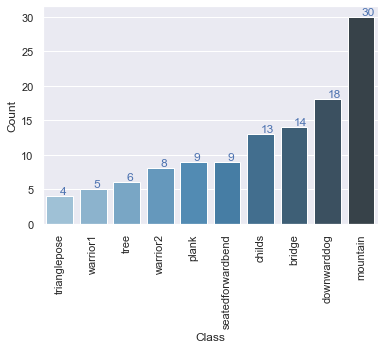

In [12]:
# illustrating the distribution of the class from the test dataset
sns.set(style = "darkgrid")
class_count_dict = defaultdict(int)
for class_val in y_test:
    class_count_dict[class_val] += 1

class_count_df = pd.DataFrame({'Class' : list(class_count_dict.keys()), 'Count' : list(class_count_dict.values())})
class_count_df = class_count_df.sort_values(['Count']).reset_index(drop = True)

bar_plot = sns.barplot(x = 'Class', y = 'Count', data = class_count_df, palette = "Blues_d")
for item in bar_plot.get_xticklabels():
    item.set_rotation(90)
for i, v in enumerate(class_count_df["Count"].iteritems()):
    bar_plot.text(i ,v[1], v[1], color = 'b', va = 'bottom')
plt.show()

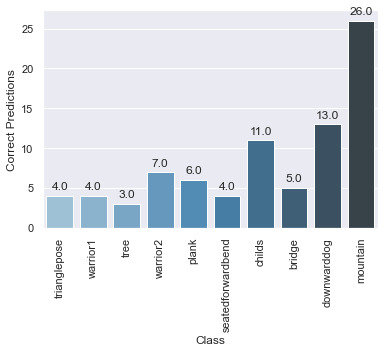

In [13]:
# illustrating the model's predicting performance for each class in terms of correct prediction (TP)
class_correct_dict = defaultdict(int)
for class_val in range(len(y_test)):
    if prediction[class_val] == y_test[class_val]:
        class_correct_dict[y_test[class_val]] += 1
        
class_correct_df = pd.DataFrame({'Class': list(class_correct_dict.keys()), 'Correct Predictions': list(class_correct_dict.values())})
order_class = list(class_count_df['Class'])

correct_pred_bar_plot = sns.barplot(x = 'Class', y = 'Correct Predictions', data = class_correct_df, order = order_class, palette = "Blues_d")
for item in correct_pred_bar_plot.get_xticklabels():
    item.set_rotation(90)

for p in correct_pred_bar_plot.patches:
    correct_pred_bar_plot.annotate(p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

In [14]:
# preprocess training dataset
df = pd.read_csv(trainfile, header = None)
df = df.replace(9999, np.nan)

def preprocess_class(df, class_name):
    df_class = df[df.iloc[:,0] == class_name]
    return df_class.iloc[:, 1:], df_class.iloc[:, 0]

# preprocess for each class 
X_bridge, y_bridge = preprocess_class(df, "bridge")
X_childs, y_childs = preprocess_class(df, "childs")
X_downwarddog, y_downwarddog = preprocess_class(df, "downwarddog")
X_mountain, y_mountain = preprocess_class(df, "mountain")
X_plank, y_plank = preprocess_class(df, "plank")
X_seatedforwardbend, y_seatedforwardbend = preprocess_class(df, "seatedforwardbend")
X_tree, y_tree = preprocess_class(df, "tree")
X_trianglepose, y_trianglepose = preprocess_class(df, "trianglepose")
X_warrior1, y_warrior1 = preprocess_class(df, "warrior1")
X_warrior2, y_warrior2 = preprocess_class(df, "warrior2")

# number of instances of each class in th training set
train_instances = {"bridge": len(X_bridge), "childs": len(X_childs),
    "downwarddog": len(X_downwarddog), "mountain": len(X_mountain), 
    "plank": len(X_plank), "seatedforwardbend": len(X_seatedforwardbend),
    "tree": len(X_tree), "trianglepose": len(X_trianglepose),
    "warrior1": len(X_warrior1), "warrior2": len(X_warrior2)}

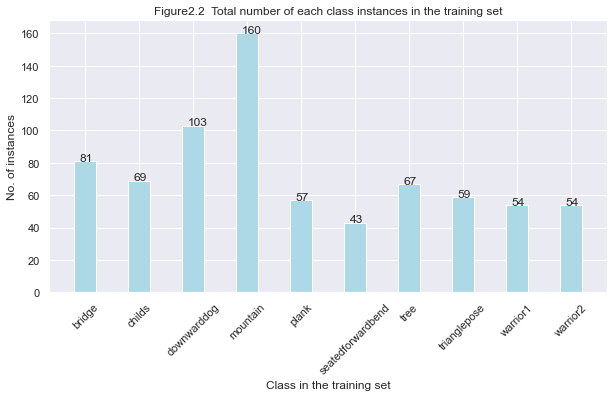

In [15]:
# creating the bar plot for the total number of each class instances in the training set

train_instances_class = list(train_instances.keys())
train_instances_total = list(train_instances.values())
fig = plt.figure(figsize = (10, 5))
 
for index, value in enumerate(train_instances_class):
    plt.text(index-0.1, train_instances_total[index], str(train_instances_total[index]))
    
plt.bar(train_instances_class, train_instances_total, color ='lightblue', width = 0.4)
plt.xticks(rotation = 45)
plt.xlabel("Class in the training set")
plt.ylabel("No. of instances")
plt.title("Figure2.2  Total number of each class instances in the training set")
plt.show()

In [16]:
#train data
bridge_data = X_bridge.values.tolist()
childs_data = X_childs.values.tolist()
downwarddog_data = X_downwarddog.values.tolist()
mountain_data = X_mountain.values.tolist()
plank_data = X_plank.values.tolist()
seatedforwardbend_data = X_seatedforwardbend.values.tolist()
tree_data = X_tree.values.tolist()
trianglepose_data = X_trianglepose.values.tolist()
warrior1_data = X_warrior1.values.tolist()
warrior2_data = X_warrior2.values.tolist()
bridge_label = y_bridge.values.tolist()
childs_label = y_childs.values.tolist()
downwarddog_label = y_downwarddog.values.tolist()
mountain_label = y_mountain.values.tolist()
plank_label = y_plank.values.tolist()
seatedforwardbend_label = y_seatedforwardbend.values.tolist()
tree_label = y_tree.values.tolist()
trianglepose_label = y_trianglepose.values.tolist()
warrior1_label = y_warrior1.values.tolist()
warrior2_label = y_warrior2.values.tolist()

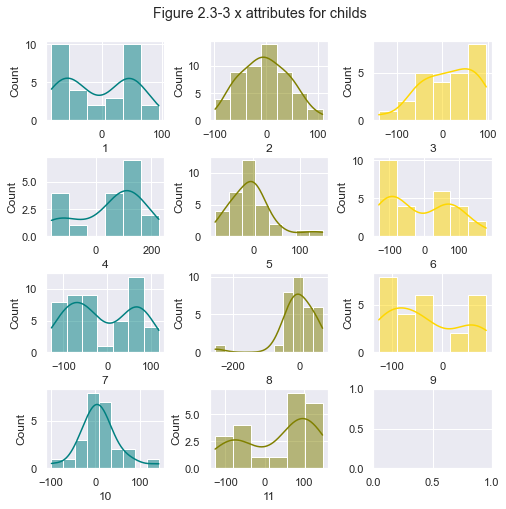

In [17]:
### Note: please use the latest version of seaborn ###

# x attributes for childs
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style = "darkgrid")
fig, axs = plt.subplots(4, 3, figsize = (7, 7))
fig.suptitle("Figure 2.3-3 x attributes for childs")
fig.tight_layout()
sns.histplot(data = X_childs, x = 1, kde = True, color = "teal", ax = axs[0, 0])
sns.histplot(data = X_childs, x = 2, kde = True, color = "olive", ax = axs[0, 1])
sns.histplot(data = X_childs, x = 3, kde = True, color = "gold", ax = axs[0, 2])
sns.histplot(data = X_childs, x = 4, kde = True, color = "teal", ax = axs[1, 0])
sns.histplot(data = X_childs, x = 5, kde = True, color = "olive", ax = axs[1, 1])
sns.histplot(data = X_childs, x = 6, kde = True, color = "gold", ax = axs[1, 2])
sns.histplot(data = X_childs, x = 7, kde = True, color = "teal", ax = axs[2, 0])
sns.histplot(data = X_childs, x = 8, kde = True, color = "olive", ax = axs[2, 1])
sns.histplot(data = X_childs, x = 9, kde = True, color = "gold", ax = axs[2, 2])
sns.histplot(data = X_childs, x = 10, kde = True, color = "teal", ax = axs[3, 0])
sns.histplot(data = X_childs, x = 11, kde = True, color = "olive", ax = axs[3, 1])
plt.show()

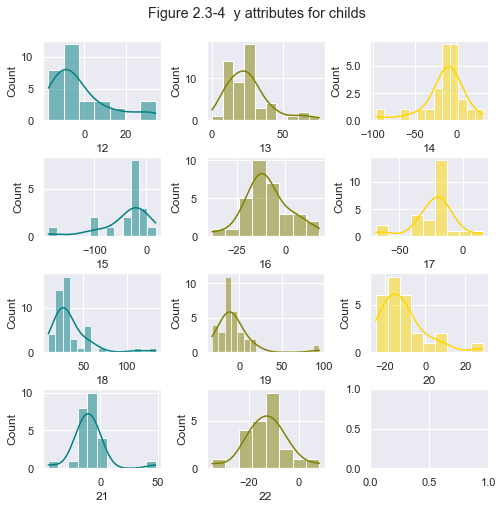

In [18]:
# y attributes for childs
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style = "darkgrid")
fig, axs = plt.subplots(4, 3, figsize = (7, 7))
fig.suptitle("Figure 2.3-4  y attributes for childs")
fig.tight_layout()
sns.histplot(data = X_childs, x = 12, kde = True, color = "teal", ax = axs[0, 0])
sns.histplot(data = X_childs, x = 13, kde = True, color = "olive", ax = axs[0, 1])
sns.histplot(data = X_childs, x = 14, kde = True, color = "gold", ax = axs[0, 2])
sns.histplot(data = X_childs, x = 15, kde = True, color = "teal", ax = axs[1, 0])
sns.histplot(data = X_childs, x = 16, kde = True, color = "olive", ax = axs[1, 1])
sns.histplot(data = X_childs, x = 17, kde = True, color = "gold", ax = axs[1, 2])
sns.histplot(data = X_childs, x = 18, kde = True, color = "teal", ax = axs[2, 0])
sns.histplot(data = X_childs, x = 19, kde = True, color = "olive", ax = axs[2, 1])
sns.histplot(data = X_childs, x = 20, kde = True, color = "gold", ax = axs[2, 2])
sns.histplot(data = X_childs, x = 21, kde = True, color = "teal", ax = axs[3, 0])
sns.histplot(data = X_childs, x = 22, kde = True, color = "olive", ax = axs[3, 1])
plt.show()

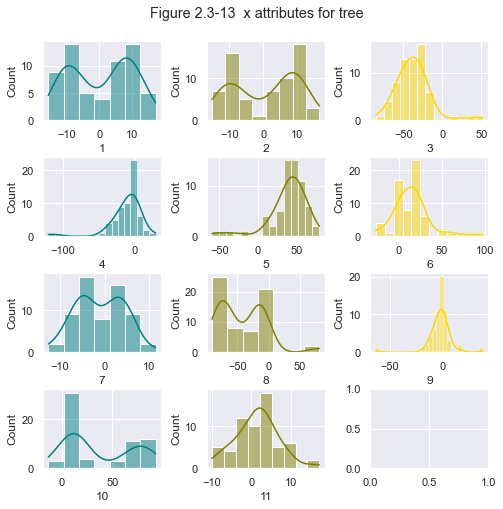

In [19]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style = "darkgrid")
fig, axs = plt.subplots(4, 3, figsize = (7, 7))
fig.suptitle("Figure 2.3-13  x attributes for tree")
fig.tight_layout()
sns.histplot(data = X_tree, x = 1, kde = True, color = "teal", ax = axs[0, 0])
sns.histplot(data = X_tree, x = 2, kde = True, color = "olive", ax = axs[0, 1])
sns.histplot(data = X_tree, x = 3, kde = True, color = "gold", ax = axs[0, 2])
sns.histplot(data = X_tree, x = 4, kde = True, color = "teal", ax = axs[1, 0])
sns.histplot(data = X_tree, x = 5, kde = True, color = "olive", ax = axs[1, 1])
sns.histplot(data = X_tree, x = 6, kde = True, color = "gold", ax = axs[1, 2])
sns.histplot(data = X_tree, x = 7, kde = True, color = "teal", ax = axs[2, 0])
sns.histplot(data = X_tree, x = 8, kde = True, color = "olive", ax = axs[2, 1])
sns.histplot(data = X_tree, x = 9, kde = True, color = "gold", ax = axs[2, 2])
sns.histplot(data = X_tree, x = 10, kde = True, color = "teal", ax = axs[3, 0])
sns.histplot(data = X_tree, x = 11, kde = True, color = "olive", ax = axs[3, 1])
plt.show()

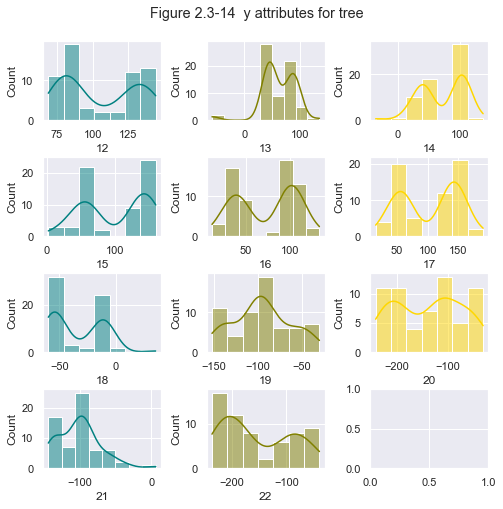

In [20]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style = "darkgrid")
fig, axs = plt.subplots(4, 3, figsize = (7, 7))
fig.suptitle("Figure 2.3-14  y attributes for tree")
fig.tight_layout()
sns.histplot(data = X_tree, x = 12, kde = True, color = "teal", ax = axs[0, 0])
sns.histplot(data = X_tree, x = 13, kde = True, color = "olive", ax = axs[0, 1])
sns.histplot(data = X_tree, x = 14, kde = True, color = "gold", ax = axs[0, 2])
sns.histplot(data = X_tree, x = 15, kde = True, color = "teal", ax = axs[1, 0])
sns.histplot(data = X_tree, x = 16, kde = True, color = "olive", ax = axs[1, 1])
sns.histplot(data = X_tree, x = 17, kde = True, color = "gold", ax = axs[1, 2])
sns.histplot(data = X_tree, x = 18, kde = True, color = "teal", ax = axs[2, 0])
sns.histplot(data = X_tree, x = 19, kde = True, color = "olive", ax = axs[2, 1])
sns.histplot(data = X_tree, x = 20, kde = True, color = "gold", ax = axs[2, 2])
sns.histplot(data = X_tree, x = 21, kde = True, color = "teal", ax = axs[3, 0])
sns.histplot(data = X_tree, x = 22, kde = True, color = "olive", ax = axs[3, 1])
plt.show()

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [21]:
'''
This function takes as its input: a 2D array containing the instances (excluding the class), and a list of the class that correspond to each instance
It calculates the prior probabilities of each class, and for each given class, and gives an arbitrary kernel bandwidth (between 5 to 25)
It returns a dictionary ("prior_prob") that stores the prior probabilities of each class in which the keys are the class, and the values are the probabilities
and the value of the kernel bandwidth
'''
def train_KDE(attribute_values, class_values):
    
    # total number of instance
    total_instance = len(class_values)
    
    # total number of attribute
    att_num = len(attribute_values[0])
    
    prior_prob = defaultdict(float)
    class_instances_dict = defaultdict(list)
    
    # count the number of instances for each class 
    for instance in range(0, total_instance):
        prior_prob[class_values[instance]] += 1
        class_instances_dict[class_values[instance]].append(attribute_values[instance])
        
    # calculate the prior probabilities   
    for class_val in prior_prob.keys():
        prior_prob[class_val] = prior_prob[class_val] / total_instance
    
    # get an arbitrary KDE between 5 and 25
    # the random state set to keep the consistency of the result
    random_state = np.random.RandomState(6)
    KDE_sigma = random_state.randint(low = 5, high = 25)
    
    return prior_prob, KDE_sigma, class_instances_dict

In [22]:
'''
This function takes in three arguments:
sigma: bandwidth for kde
X_test_row: row of test instance
X_train_per_class: dictionary with class label as a key and list of instances of the class in the training set as value, 
calculates likelihood for each class
and returns as a dictionary in a form: {'class': SUM(log(P(xi|class)))}
'''
def get_likelihood(sigma, X_test_row, X_train_per_class):

    likelihood_dict = {}
    
    for class_label in X_train_per_class.keys():
        #likelohood
        pxs = 0
        # check all the test instances
        for xi_test in range(len(X_test_row)):
            # pobability of getting X_test_row[xi_test] given the class: (SUM(thi(x - xn)) / N)
            px = 0
            if not np.isnan(X_test_row[xi_test]):
                for xn_row in  X_train_per_class[class_label]:
                    if not np.isnan(xn_row[xi_test]):
                        px += math.exp(- (1 / 2) * math.pow((X_test_row[xi_test] - xn_row[xi_test]) / sigma, 2)) / (sigma * math.sqrt(2 * math.pi))  
                    #ignore nan
                    else: 
                        continue;
            #ignore nan
            else:
                continue;
            
            # X_train_per_class has at least one instance as the value
            px = px / len(X_train_per_class[class_label])
        
            if px > 0:
                pxs += math.log(px, 2)
                
            else:
                #pxs will be very small as the px gets close to 0
                # so added large negitive number
                pxs += -9999    
                
        likelihood_dict[class_label] = pxs
        
    return likelihood_dict


'''
This dunction takes priors (priors), bandwidth (sigma), 
attributes of an instance from the test set (X_test_row), 
dictionary of instances for each class in the training set (X_train_per_class).
Returns a dictionary of the posterior probabilities (values) for each class (key) 
'''
def get_posterior(priors, sigma, X_test_row, X_train_per_class):
    
    likelihood_dict = get_likelihood(sigma, X_test_row, X_train_per_class)
    
    # calculate posterior for each class in log
    #P(class|x) = log{prior[class]} + SUM(log(P(xi|class)))
    posteriors = {}
    for label in priors.keys():
        posteriors[label] = math.log(priors[label], 2) + likelihood_dict[label]
        
    return posteriors


'''
This function takes dictionary of priors (priors), bandwidth (sigma), 
attributes of the test set (X_test), dictionary of instances for each class
in the training set (X_train_per_class).
Returns the predicted class label for the test set.
'''
def predict_KDE(priors, sigma, X_test, X_train_per_class):
    
    y_test_predict = []
    
    for row in X_test:
        posterior = get_posterior(priors, sigma, row, X_train_per_class)
        y_test_predict.append(max(posterior, key = posterior.get))
    
    return y_test_predict 

In [23]:
def KDE(trainfile, testfile):
    # preprocess
    X_train, y_train = preprocess(trainfile)
    X_test, y_test = preprocess(testfile)

    # train
    priors, sigma, X_train_per_class = train_KDE(X_train, y_train)

    # test
    y_test_predict_kde = predict_KDE(priors, sigma, X_test, X_train_per_class)

    # evaluate
    return evaluate(y_test_predict_kde, y_test)

KDE(trainfile, testfile)

(0.7068965517241379,
 defaultdict(list,
             {'bridge': [0.8571428571428571,
               0.42857142857142855,
               0.5714285714285714],
              'childs': [0.8571428571428571, 0.46153846153846156, 0.6],
              'downwarddog': [0.9090909090909091,
               0.5555555555555556,
               0.6896551724137931],
              'mountain': [0.8666666666666667,
               0.8666666666666667,
               0.8666666666666667],
              'plank': [0.4117647058823529,
               0.7777777777777778,
               0.5384615384615384],
              'seatedforwardbend': [0.5384615384615384,
               0.7777777777777778,
               0.6363636363636364],
              'tree': [0.5, 1.0, 0.6666666666666666],
              'trianglepose': [0.5, 1.0, 0.6666666666666666],
              'warrior1': [0.75, 0.6, 0.6666666666666665],
              'warrior2': [1.0, 0.875, 0.9333333333333333]}))

In [24]:
# preprocess the data files
X_train, y_train = preprocess(trainfile)
X_test, y_test = preprocess(testfile)

# train the KDE model
priors, sigma, X_train_per_class = train_KDE(X_train, y_train)

# get the prediction from the KDE model
y_test_predict_kde = predict_KDE(priors, sigma, X_test, X_train_per_class)

In [25]:
# Macro-averaging evalution for KDE Naive Bayes
macro_averaging(y_test_predict_kde, y_test)

(0.6975877192982456, 0.7078296703296703, 0.6880317810967098)

In [26]:
# Micro-averaging evalution for KDE Naive Bayes
micro_averaging(y_test_predict_kde, y_test)

(0.7068965517241379, 0.7068965517241379, 0.7068965517241379)

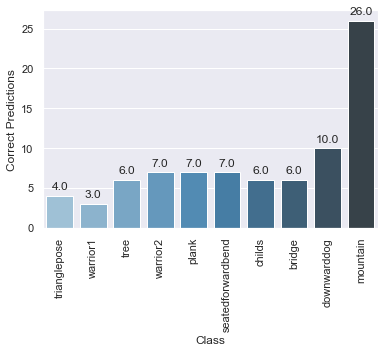

In [27]:
# illustrating the KDE model's predicting performance for each class in terms of correct prediction (TP)
class_correct_dict = defaultdict(int)
for class_val in range(len(y_test)):
    if y_test_predict_kde[class_val] == y_test[class_val]:
        class_correct_dict[y_test[class_val]] += 1
        
class_correct_df = pd.DataFrame({'Class': list(class_correct_dict.keys()), 'Correct Predictions': list(class_correct_dict.values())})
order_class = list(class_count_df['Class'])

correct_pred_bar_plot = sns.barplot(x = 'Class', y = 'Correct Predictions', data = class_correct_df, order = order_class, palette="Blues_d")
for item in correct_pred_bar_plot.get_xticklabels():
    item.set_rotation(90)

for p in correct_pred_bar_plot.patches:
    correct_pred_bar_plot.annotate(p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [28]:
# get class_bridge's prediction values to understand Gaussian's mislabelling
bridge_pred_count = defaultdict(int)
for val in range(len(y_test)):
    if y_test[val] == 'bridge':
        bridge_pred_count[prediction[val]] += 1
for val in bridge_pred_count.keys():
    print(val, ': ', bridge_pred_count[val])

downwarddog :  5
childs :  3
bridge :  5
plank :  1


childs
feature:  1


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


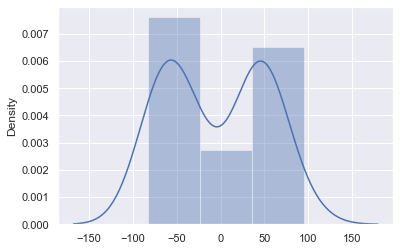

feature:  2


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


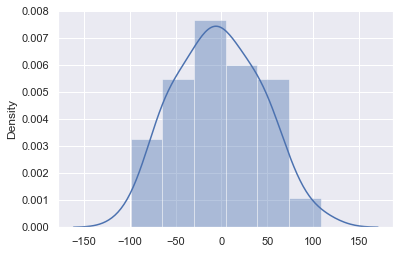

feature:  3


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


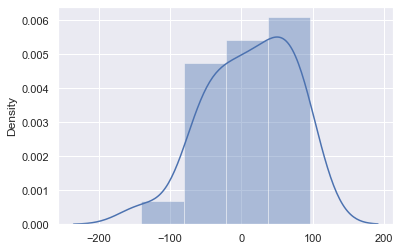

feature:  4


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


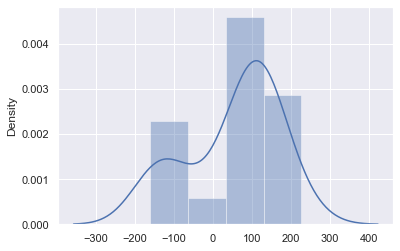

feature:  5


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


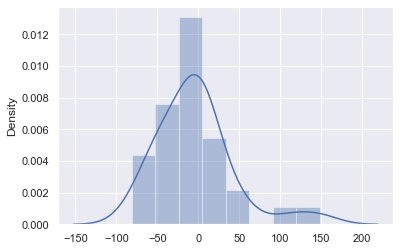

feature:  6


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


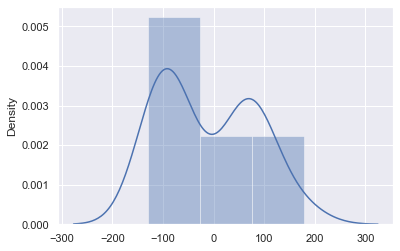

feature:  7


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


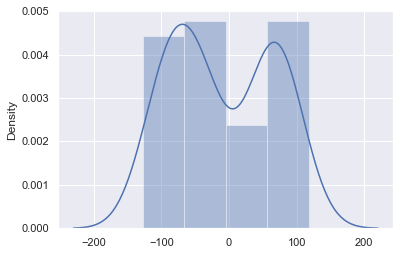

feature:  8


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


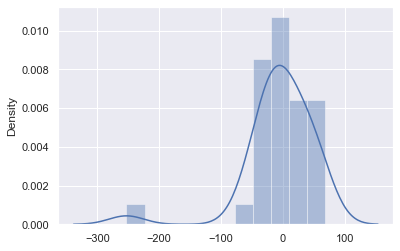

feature:  9


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


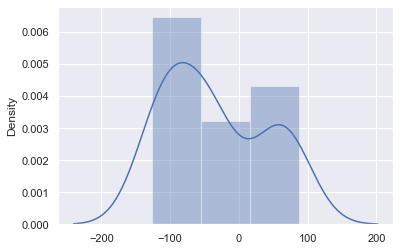

feature:  10


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


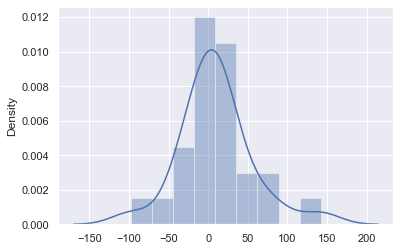

feature:  11


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


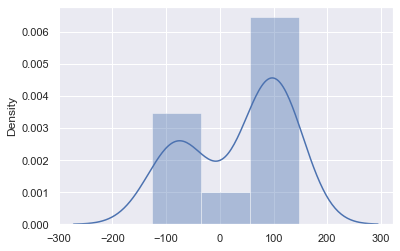

feature:  12


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


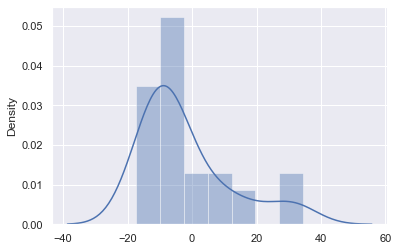

feature:  13


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


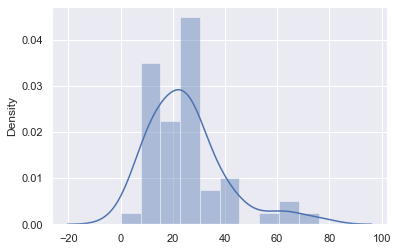

feature:  14


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


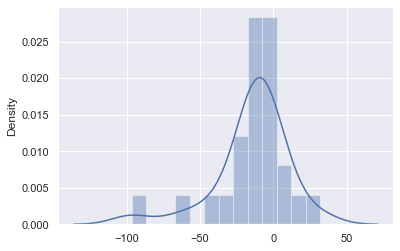

feature:  15


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


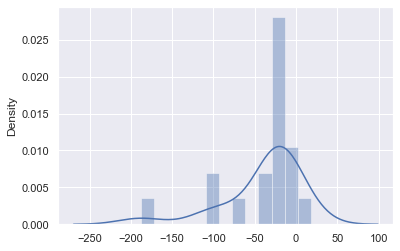

feature:  16


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


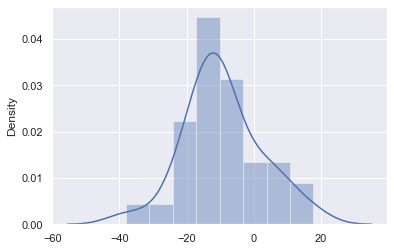

feature:  17


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


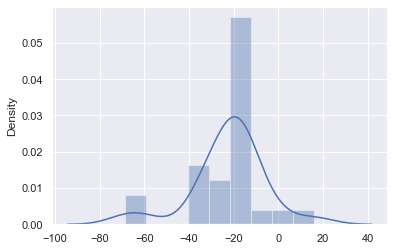

feature:  18


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


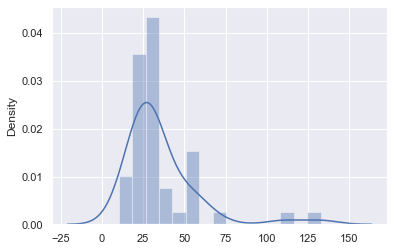

feature:  19


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


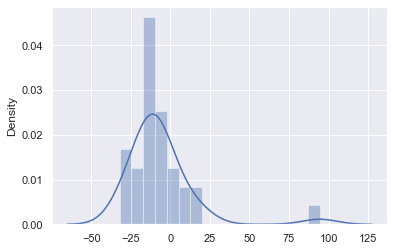

feature:  20


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


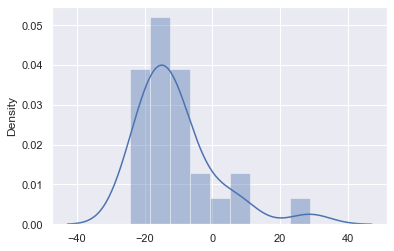

feature:  21


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


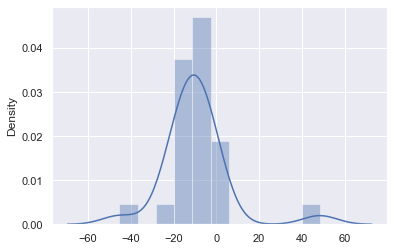

feature:  22


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


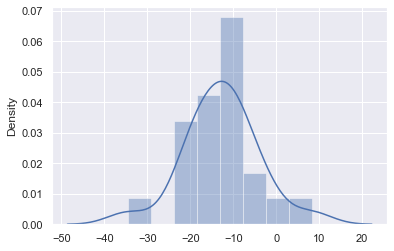

In [29]:
# illustrate the feature distrbution of class childs
train_dataset_df = pd.read_csv(trainfile, header = None)
train_dataset_df = train_dataset_df.replace(9999, np.nan) 
class_val = []
for val in train_dataset_df[0]:
    if val not in class_val:
        class_val.append(val)
        
print(class_val[1])
for j in range(1, 23):
    print("feature: ", j)
    data = train_dataset_df.groupby([0])[j].apply(list)
    new_data = []
    for val in data[1]:
        if not(np.isnan(val)):
            new_data.append(val)
    
    sns.distplot(new_data)
    plt.show()

seatedforwardbend
feature:  1


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


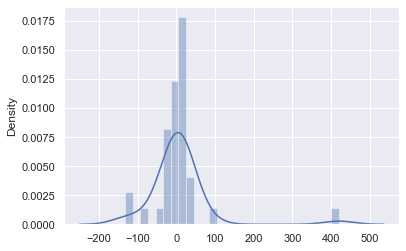

feature:  2


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


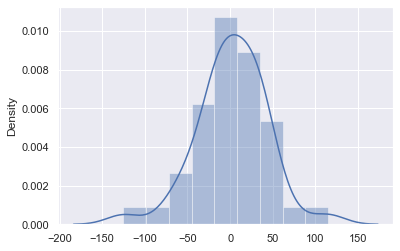

feature:  3


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


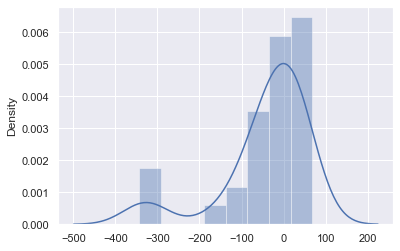

feature:  4


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


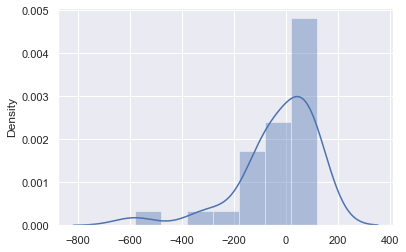

feature:  5


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


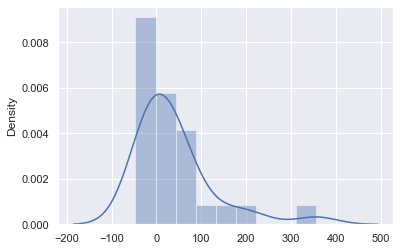

feature:  6


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


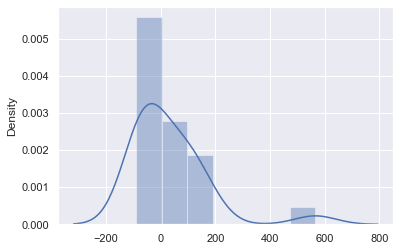

feature:  7


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


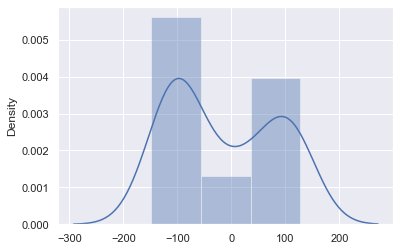

feature:  8


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


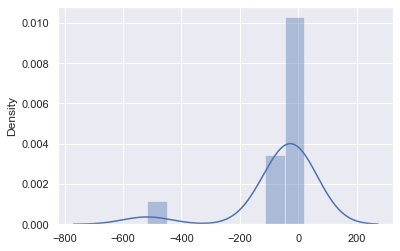

feature:  9


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


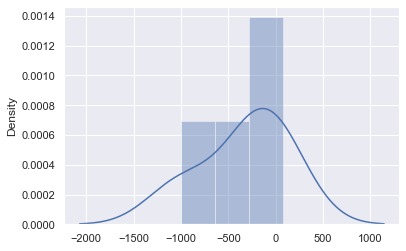

feature:  10


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


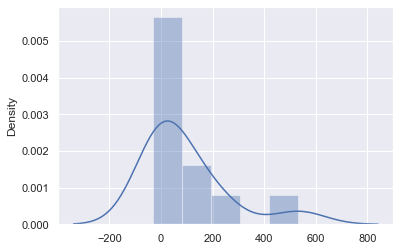

feature:  11


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


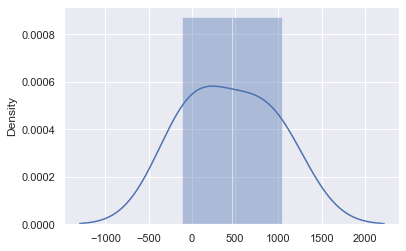

feature:  12


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


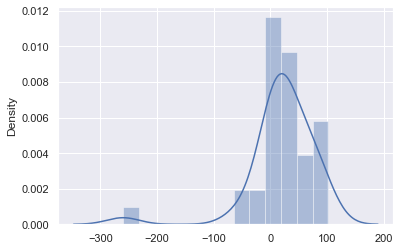

feature:  13


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


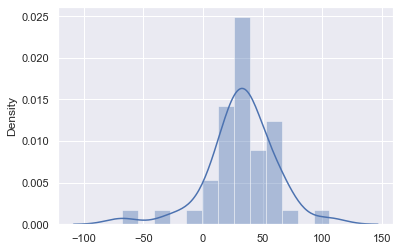

feature:  14


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


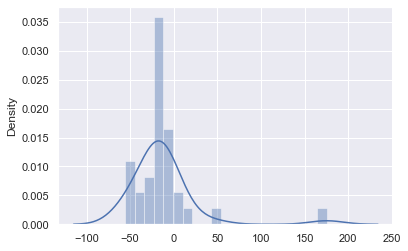

feature:  15


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


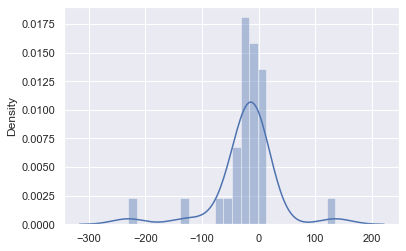

feature:  16


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


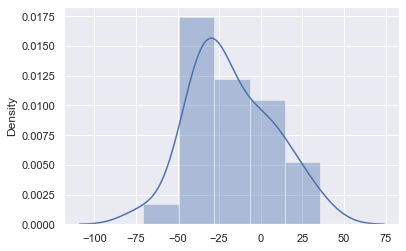

feature:  17


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


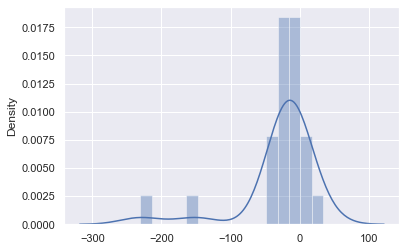

feature:  18


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


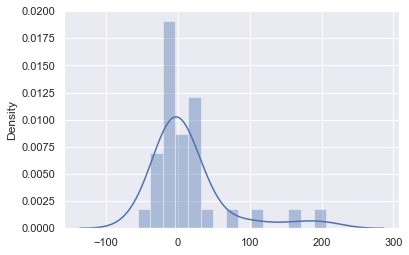

feature:  19


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


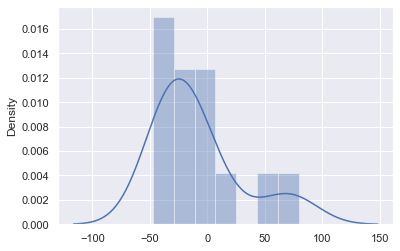

feature:  20


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


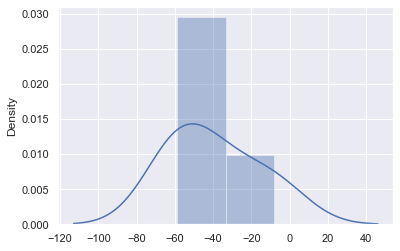

feature:  21


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


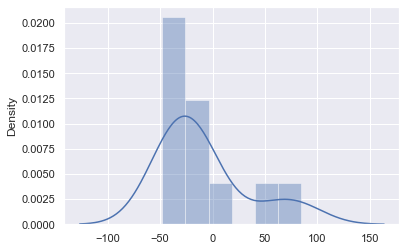

feature:  22


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


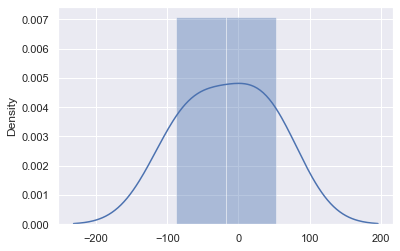

In [30]:
# illustrate the feature distrbution of class seated forward bend
print(class_val[5])
for j in range(1, 23):
    print("feature: ", j)
    data = train_dataset_df.groupby([0])[j].apply(list)
    new_data = []
    for val in data[5]:
        if not(np.isnan(val)):
            new_data.append(val)
    
    sns.distplot(new_data)
    plt.show()

bridge
feature:  12


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


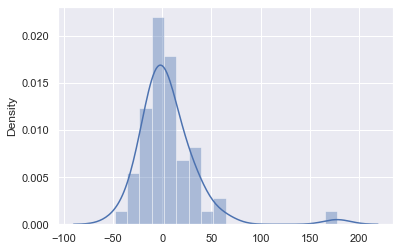

feature:  13


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


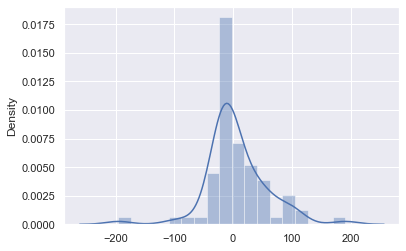

feature:  14


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


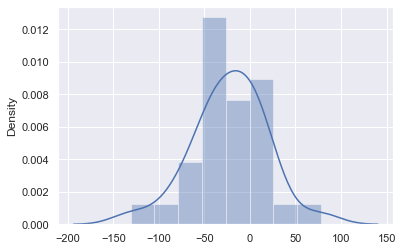

feature:  15


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


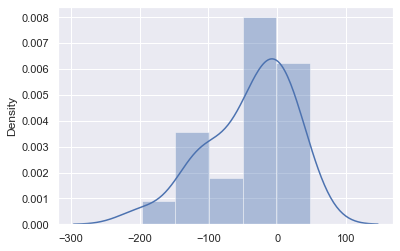

feature:  16


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


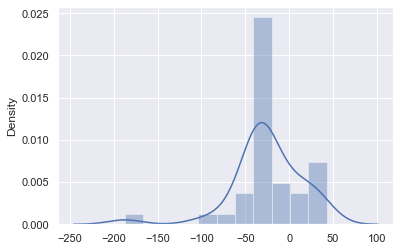

feature:  17


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


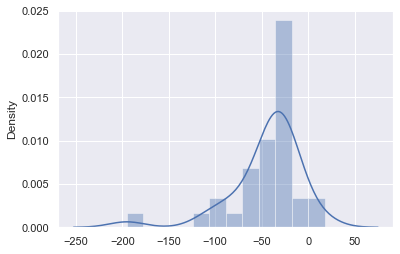

feature:  18


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


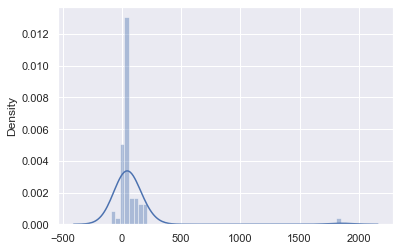

feature:  19


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


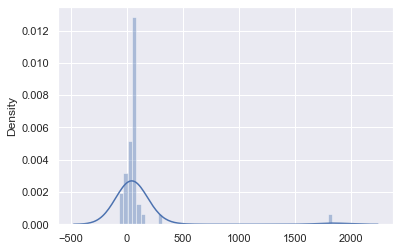

feature:  20


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


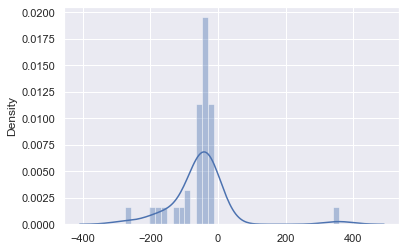

feature:  21


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


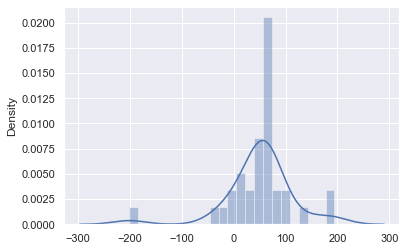

feature:  22


C:\Users\taiya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


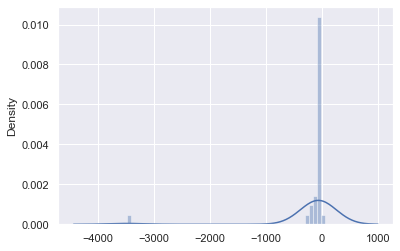

In [31]:
# illustrate the feature distrbution of class bridge
print(class_val[0])
for j in range(12, 23):
    print("feature: ", j)
    data = train_dataset_df.groupby([0])[j].apply(list)
    new_data = []
    for val in data[0]:
        if not(np.isnan(val)):
            new_data.append(val)
    
    sns.distplot(new_data)
    plt.show()

### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

In [32]:
# preprocess
X_train, y_train = preprocess(trainfile)
X_test, y_test = preprocess(testfile)

In [33]:
# random hold out: 8:2 split, random state is set to keep the consistency of the result
X, X_validation, y, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

# get an arbitrary KDE between 5 and 25
sigmas_accuracy = dict()
prior_random_holdout, no_use, X_train_per_class  = train_KDE(X, y)
for sigma in range(5, 26):
    y_validation_predict_KDE = predict_KDE(prior_random_holdout, sigma, X_validation, X_train_per_class)
    sigmas_accuracy[sigma], dummy_dict = evaluate(y_validation_predict_KDE, y_validation)

# best band width between 5-25
best_sigma = max(sigmas_accuracy, key = sigmas_accuracy.get)    

In [34]:
# train
priors, no_use, X_train_per_class = train_KDE(X_train, y_train)

# predict
y_test_predict_kde = predict_KDE(priors, best_sigma, X_test, X_train_per_class)

# accuracy of the model for the best bandwidth
accuracy, dummydict = evaluate(y_test_predict_kde, y_test)

print(f"bandwidth: {best_sigma}")
print(f"accuracy for the test set with the selected bandwidth: {accuracy}")

# accuracy for each sigma in the validation set
print("\naccuracy for the validation set for each bandwidth")
sigmas_accuracy

bandwidth: 5
accuracy for the test set with the selected bandwidth: 0.7241379310344828

accuracy for the validation set for each bandwidth


{5: 0.8133333333333334,
 6: 0.7933333333333333,
 7: 0.7933333333333333,
 8: 0.7933333333333333,
 9: 0.7933333333333333,
 10: 0.7933333333333333,
 11: 0.7933333333333333,
 12: 0.7933333333333333,
 13: 0.7933333333333333,
 14: 0.8,
 15: 0.8,
 16: 0.7933333333333333,
 17: 0.7933333333333333,
 18: 0.7933333333333333,
 19: 0.7733333333333333,
 20: 0.7733333333333333,
 21: 0.7666666666666667,
 22: 0.76,
 23: 0.7533333333333333,
 24: 0.7466666666666667,
 25: 0.7466666666666667}

In [35]:
# accuracy for each sigma for the test set (after trained using training set from train.csv)
sigmas_accuracy_test = dict()
priors, no_use, X_train_per_class = train_KDE(X_train, y_train)
for sigma in range(5, 26):
    y_test_predict_kde = predict_KDE(priors, sigma, X_test, X_train_per_class)
    sigmas_accuracy_test[sigma], dummy_dict = evaluate(y_test_predict_kde, y_test)
    
print("accuracy for the test set for each bandwidth")
sigmas_accuracy_test

accuracy for the test set for each bandwidth


{5: 0.7241379310344828,
 6: 0.7241379310344828,
 7: 0.7241379310344828,
 8: 0.7155172413793104,
 9: 0.7155172413793104,
 10: 0.7155172413793104,
 11: 0.6982758620689655,
 12: 0.7068965517241379,
 13: 0.7155172413793104,
 14: 0.6982758620689655,
 15: 0.7068965517241379,
 16: 0.7068965517241379,
 17: 0.7068965517241379,
 18: 0.6982758620689655,
 19: 0.6810344827586207,
 20: 0.6810344827586207,
 21: 0.6724137931034483,
 22: 0.6724137931034483,
 23: 0.6637931034482759,
 24: 0.6637931034482759,
 25: 0.6551724137931034}

Text(0.5, 1.0, 'Figure 4.1  Prediction accuracy of KDE for the bandwidth between 5-25\n')

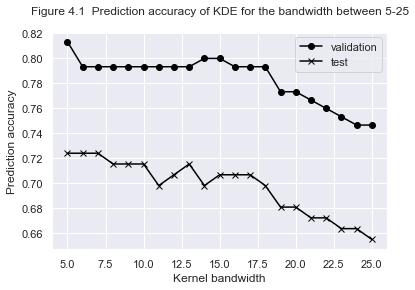

In [36]:
#plot the prediction accuracy of KDE for the bandwidth between 5-25
sigma_x = list(sigmas_accuracy.keys())
sigma_y = list(sigmas_accuracy.values())
sigmat_x = list(sigmas_accuracy_test.keys())
sigmat_y = list(sigmas_accuracy_test.values())


plt.plot(sigma_x, sigma_y, '-ok', color = 'black', label = "validation");
plt.plot(sigmat_x, sigmat_y, '-xk', color = 'black', label = "test");
plt.legend(numpoints = 1)
plt.xlabel("Kernel bandwidth")
plt.ylabel("Prediction accuracy")
plt.title("Figure 4.1  Prediction accuracy of KDE for the bandwidth between 5-25\n")

### Q5
Naive Bayes ignores missing values, but in pose recognition tasks the missing values can be informative. Missing values indicate that some part of the body was obscured and sometimes this is relevant to the pose (e.g., holding one hand behind the back). Are missing values useful for this task? Implement a method that incorporates information about missing values and demonstrate whether it changes the classification results.

### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.